# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio
import cv2
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.set_random_seed(30)

Download the datasize & unzip it

In [3]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 1.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=888ba37c79335b7d7f3aa63762e323d0079885248d4880d0a0f6abc00df5d955
  Stored in directory: /home/.cache/pip/wheels/7b/7b/5d/656f46cd6889e4c93977be9586901d0adc1271b2d876c84c96
Successfully built gdown
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
import gdown
url = 'https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'
output = 'Project_data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /home/Project_data.zip
100%|██████████| 1.71G/1.71G [01:48<00:00, 15.7MB/s]


'Project_data.zip'

In [5]:
!unzip 'Project_data.zip'

Archive:  Project_data.zip
   creating: Project_data/
   creating: Project_data/train/
  inflating: Project_data/train.csv  
   creating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00014.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00016.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00018.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00020.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00022.png  
  inflating: Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00024.png  
  inflating: Pro

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

## Plotting

In [3]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.show()

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
num_classes=5
print ('# num_classes =', num_classes)
total_frames=30

# num_classes = 5


In [6]:
def one_batch_data(source_path,t,batch,batch_size,img_idx,augment, height, width,remaining_seq=0):
    
    seq_len = remaining_seq if remaining_seq else batch_size
    
    batch_data = np.zeros((seq_len,len(img_idx),height,width,3)) 
    batch_labels = np.zeros((seq_len,num_classes)) 
    
    if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),height,width,3))

        
    for folder in range(seq_len): 
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
        for idx,item in enumerate(img_idx):
            #performing image reading and resizing
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image_resized=cv2.resize(image,(height,width))
            
            #normalizing the images
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
            if (augment):
                shifted = cv2.warpAffine(image, 
                                         np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                         (image.shape[1], image.shape[0]))
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                # cropping the images to have the targeted gestures and remove the noise from the images.
                cropped=shifted[x0:x1,y0:y1,:]
                    
                image_resized=cv2.resize(cropped,(height,width))
                    
                batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
    if (augment):
        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])

        
    return(batch_data,batch_labels)

In [7]:
 def generator(source_path, folder_list, batch_size, sample_frames,height, width, augment=False):
        img_idx = np.round(np.linspace(0,total_frames-1,sample_frames)).astype(int)
        #batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= one_batch_data(source_path,t,batch,batch_size,img_idx,augment, height, width)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,height, width, remaining_seq)
                yield batch_data, batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation
from keras.layers import GRU, Flatten, TimeDistributed
from keras.layers import Conv2D, MaxPool2D, GlobalMaxPool2D
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

In [10]:
#write your model here
def build_3DConv_net(shape=(30,112, 112, 3), learn_rate=0.001, dense_neurons=64, dropout=0.25):
    model = keras.Sequential()
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes,activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.2,
           patience=1, verbose=1)# write the REducelronplateau code here
#earlystop = EarlyStopping( monitor="val_loss", min_delta=0.01,patience=10,verbose=1)
#callbacks_list = [checkpoint, LR,earlystop]
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Experiment 01: Try to find good batch size

In [68]:
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=30
print ('# total_frames =', total_frames)
img_height = 160
print ('# img_height =', img_height)
img_width = 160
print ('# img_width =', img_width)
batch_size = 32 #experiment with the batch size
print ('# batch_size =', batch_size)

model_01 = build_3DConv_net((sample_frames, img_height, img_width,3), dense_neurons=256)
print (model_01.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width,augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width,augment=True)

model_01_history = model_01.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 5
# total_frames = 30
# img_height = 160
# img_width = 160
# batch_size = 32
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_45 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_49 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                               

2022-06-12 09:37:11.910430: W tensorflow/core/common_runtime/bfc_allocator.cc:344] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-06-12 09:37:22.052037: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB (rounded to 3145728000)requested by op gradient_tape/sequential_28/max_pooling3d_8/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary 

ResourceExhaustedError:  OOM when allocating tensor with shape[64,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_28/max_pooling3d_8/MaxPool3D/MaxPool3DGrad
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_53138]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential_28/max_pooling3d_8/MaxPool3D/MaxPool3DGrad:
In[0] sequential_28/batch_normalization_49/FusedBatchNormV3 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py:589)	
In[1] sequential_28/max_pooling3d_8/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[2] gradient_tape/sequential_28/conv3d_9/Conv3D/Conv3DBackpropInputV2:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_418/1511400926.py", line 28, in <module>
>>>     model_01_history = model_01.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

### Results

|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|01| Model_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 02: Batch size of 20; other params remain same as Experiment 01

In [56]:
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=30
print ('# total_frames =', total_frames)
img_height = 160
print ('# img_height =', img_height)
img_width = 160
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_01 = build_3DConv_net((sample_frames, img_height, img_width,3), dense_neurons=256)
print (model_01.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width)

model_01_history = model_01.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 5
# total_frames = 30
# img_height = 160
# img_width = 160
# batch_size = 20
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                               

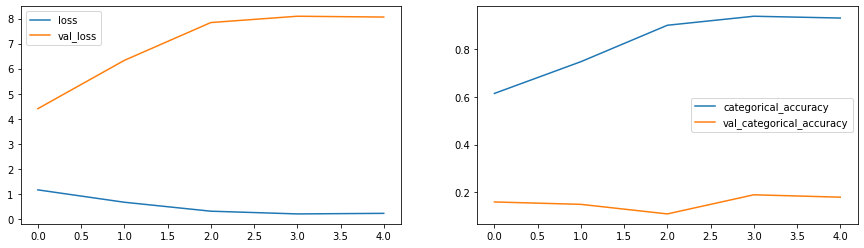

In [57]:
plot(model_01_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 03: Let's reduce dense connection to 64

In [64]:
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=30
print ('# total_frames =', total_frames)
img_height = 160
print ('# img_height =', img_height)
img_width = 160
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_02 = build_3DConv_net((sample_frames, img_height, img_width,3))
print (model_02.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width,augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_02_history = model_02.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 5
# total_frames = 30
# img_height = 160
# img_width = 160
# batch_size = 20
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_66 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                               

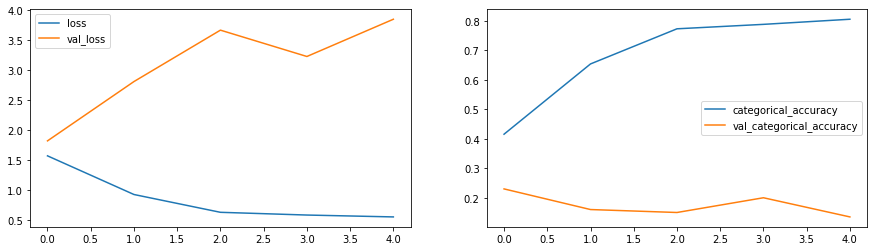

In [65]:
plot(model_02_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|03| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.8054 | 0.1350 |0.5465   | 3.8519   | <b> Model is Overfitted</b>| Let's change drop 0.25 -> 0.5|
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 04: Increase Dropout 0.25 -> 0.5

In [66]:
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=30
print ('# sample_frames =', total_frames)
img_height = 160
print ('# img_height =', img_height)
img_width = 160
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_03 = build_3DConv_net((sample_frames, img_height, img_width,3), dropout=0.5)
print (model_03.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_03_history = model_03.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 5
# sample_frames = 30
# img_height = 160
# img_width = 160
# batch_size = 20
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_72 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                              

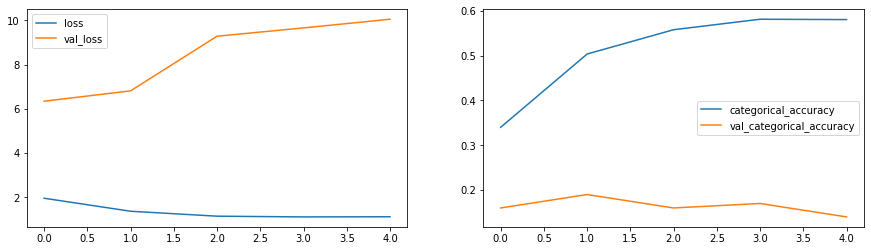

In [67]:
plot(model_03_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|04| Model_01 | 20 | 05 | 30 | 160 | 160 | 0.5807 | 0.1400 | 1.1205 | 10.0454   | <b> Model is learning though overfitting continues  </b>| Let's reduce number of frames in case model is learning noise|
|03| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.8054 | 0.1350 |0.5465   | 3.8519   | <b> Model is Overfitted</b>| Let's change drop 0.25 -> 0.5|
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 05: Reduce frames 30 -> 20

In [68]:
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=20
print ('# sample_frames =', total_frames)
img_height = 160
print ('# img_height =', img_height)
img_width = 160
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_04 = build_3DConv_net((sample_frames, img_height, img_width,3), dense_neurons=256, dropout=0.5)
print (model_04.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_04_history = model_04.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 5
# sample_frames = 30
# img_height = 160
# img_width = 160
# batch_size = 20
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_78 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 10, 80, 80, 32)    4128      
                              

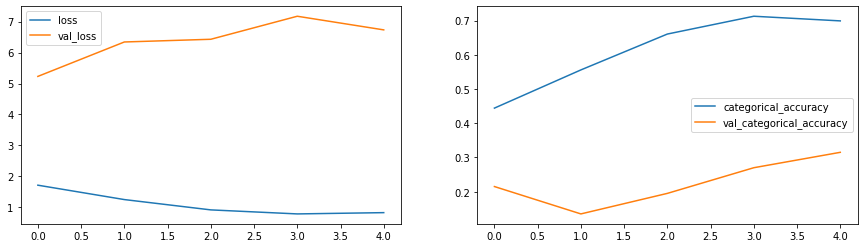

In [69]:
plot(model_04_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|05| Model_arch_01 | 20 | 05 | 20 | 160 | 160 | 0.0.6991 | 0.3150 | 0.8275 | 6.7342 | <b> Model is learning and giving better validation accuracy </b>| Let's try to change image height & width|
|04| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.5807 | 0.1400 | 1.1205 | 10.0454   | <b> Model is learning though overfitting continues  </b>| Let's reduce number of frames in case model is learning noise|
|03| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.8054 | 0.1350 |0.5465   | 3.8519   | <b> Model is Overfitted</b>| Let's change drop 0.25 -> 0.5|
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 06: Change dimension from 160 X 160 -> 120 X 120

In [70]:
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=20
print ('# sample_frames =', total_frames)
img_height = 120
print ('# img_height =', img_height)
img_width = 120
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_06 = build_3DConv_net((sample_frames, img_height, img_width,3), dense_neurons=256, dropout=0.5)
print (model_06.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_06_history = model_06.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 5
# sample_frames = 30
# img_height = 120
# img_width = 120
# batch_size = 20
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 60, 60, 32)    4128      
                              

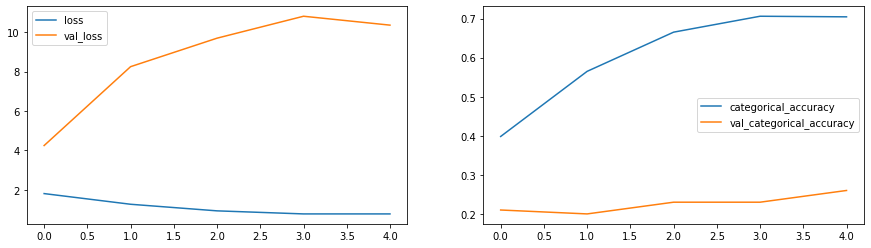

In [71]:
plot(model_06_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|06| Model_arch_01 | 20 | 05 | 20 | 120 | 120 | 0.7044 | 0.2600 | 0.7819 | 10.3581 | <b> Model is learning though validation loss is high </b>| Let's try to increase epoch count from 5->25|
|05| Model_arch_01 | 20 | 05 | 20 | 160 | 160 | 0.0.6991 | 0.3150 | 0.8275 | 6.7342 | <b> Model is learning and giving better validation accuracy </b>| Let's try to change image height & width|
|04| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.5807 | 0.1400 | 1.1205 | 10.0454   | <b> Model is learning though overfitting continues  </b>| Let's reduce number of frames in case model is learning noise|
|03| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.8054 | 0.1350 |0.5465   | 3.8519   | <b> Model is Overfitted</b>| Let's change drop 0.25 -> 0.5|
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 07: Increase epoch 05 -> 25

In [14]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=20
print ('# total_frames =', total_frames)
img_height = 120
print ('# img_height =', img_height)
img_width = 120
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_07 = build_3DConv_net((sample_frames, img_height, img_width,3), dropout=0.5)
print (model_07.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_07_history = model_07.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 25
# total_frames = 30
# img_height = 120
# img_width = 120
# batch_size = 20


2022-06-12 02:46:18.256510: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-12 02:46:18.256595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 32)   

2022-06-12 02:46:22.455880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 2.0699 - categorical_accuracy: 0.3100
Epoch 00001: saving model to model_init_2022-06-1202_45_35.425202/model-00001-2.06994-0.30995-4.17295-0.16000.h5
34/34 [==============================] - 87s 3s/step - loss: 2.0699 - categorical_accuracy: 0.3100 - val_loss: 4.1729 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5548 - categorical_accuracy: 0.4223
Epoch 00002: saving model to model_init_2022-06-1202_45_35.425202/model-00002-1.55481-0.42232-7.23674-0.20000.h5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
34/34 [==============================] - 84s 3s/step - loss: 1.5548 - categorical_accuracy: 0.4223 - val_loss: 7.2367 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3713 - categorical_accuracy: 0.4827
Epoch 00003: saving model to model_init_2022-06-1202_

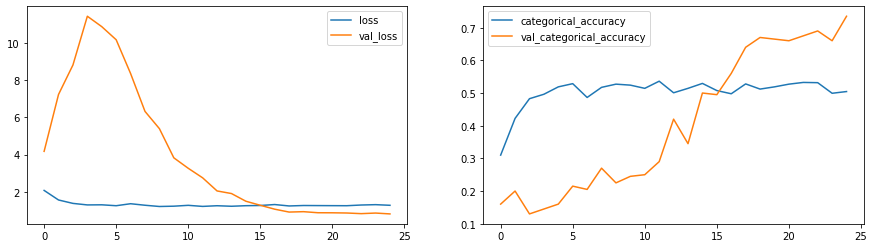

In [15]:
plot(model_07_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|07| Model_arch_01 | 20 | <b>25</b> | 20 | 120 | 120 | 0.5045 | 0.7350    | 1.2689 | 0.8047 | <b> Model is learning but underfitting can be observed </b>| Let's try to increase dense connections 64->128|
|06| Model_arch_01 | 20 | 05 | 20 | 120 | 120 | 0.7044 | 0.2600 | 0.7819 | 10.3581 | <b> Model is learning though validation loss is high </b>| Let's try to increase epoch count from 5->25|
|05| Model_arch_01 | 20 | 05 | 20 | 160 | 160 | 0.0.6991 | 0.3150 | 0.8275 | 6.7342 | <b> Model is learning and giving better validation accuracy </b>| Let's try to change image height & width|
|04| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.5807 | 0.1400 | 1.1205 | 10.0454   | <b> Model is learning though overfitting continues  </b>| Let's reduce number of frames in case model is learning noise|
|03| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.8054 | 0.1350 |0.5465   | 3.8519   | <b> Model is Overfitted</b>| Let's change drop 0.25 -> 0.5|
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 07-1: Model seems to be under performing on training data; let's try to keep more dense connection 64->128

In [21]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=20
print ('# total_frames =', total_frames)
img_height = 120
print ('# img_height =', img_height)
img_width = 120
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_08 = build_3DConv_net((sample_frames, img_height, img_width,3), dense_neurons=128, dropout=0.5)
print (model_08.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_08_history = model_08.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 25
# total_frames = 30
# img_height = 120
# img_width = 120
# batch_size = 20
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 32)    4128      
                               

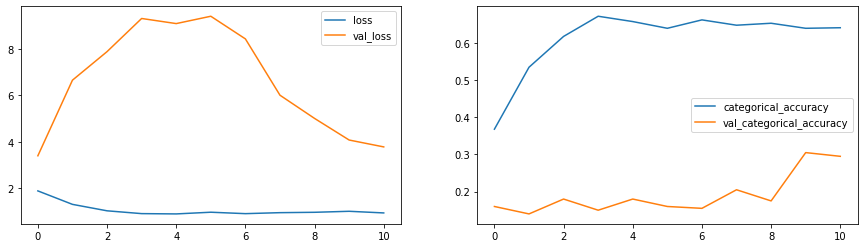

In [22]:
plot(model_08_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|08| Model_arch_01 | 20 | <b>25</b> | 20 | 120 | 120 | 0.6410 | 0.3050 | 0.9323 | 3.7757 | <b> Model is learning but overfitting can be observed </b>| Let's try to keep same set up as experiment 07 and consider dropout change 0.5->0.25|
|07| Model_arch_01 | 20 | <b>25</b> | 20 | 120 | 120 | 0.5045 | 0.7350    | 1.2689 | 0.8047 | <b> Model is learning but underfitting can be observed </b>| Let's try to increase dense connections 64->128|
|06| Model_arch_01 | 20 | 05 | 20 | 120 | 120 | 0.7044 | 0.2600 | 0.7819 | 10.3581 | <b> Model is learning though validation loss is high </b>| Let's try to increase epoch count from 5->25|
|05| Model_arch_01 | 20 | 05 | 20 | 160 | 160 | 0.0.6991 | 0.3150 | 0.8275 | 6.7342 | <b> Model is learning and giving better validation accuracy </b>| Let's try to change image height & width|
|04| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.5807 | 0.1400 | 1.1205 | 10.0454   | <b> Model is learning though overfitting continues  </b>| Let's reduce number of frames in case model is learning noise|
|03| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.8054 | 0.1350 |0.5465   | 3.8519   | <b> Model is Overfitted</b>| Let's change drop 0.25 -> 0.5|
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

## Experiment 09: Let's reduce dense connection 128->64 and dropout 0.5->0.25 

In [20]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=20
print ('# total_frames =', total_frames)
img_height = 120
print ('# img_height =', img_height)
img_width = 120
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_09 = build_3DConv_net((sample_frames, img_height, img_width,3), dense_neurons=128, dropout=0.25)
print (model_09.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_09_history = model_09.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 25
# total_frames = 30
# img_height = 120
# img_width = 120
# batch_size = 20


2022-06-12 06:54:03.172663: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-12 06:54:03.172723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 32)   

2022-06-12 06:54:07.417230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.5133 - categorical_accuracy: 0.4359
Epoch 00001: saving model to model_init_2022-06-1206_53_22.543736/model-00001-1.51332-0.43590-3.65149-0.16000.h5
34/34 [==============================] - 87s 2s/step - loss: 1.5133 - categorical_accuracy: 0.4359 - val_loss: 3.6515 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.8903 - categorical_accuracy: 0.6644
Epoch 00002: saving model to model_init_2022-06-1206_53_22.543736/model-00002-0.89025-0.66440-5.10294-0.21500.h5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
34/34 [==============================] - 83s 3s/step - loss: 0.8903 - categorical_accuracy: 0.6644 - val_loss: 5.1029 - val_categorical_accuracy: 0.2150 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.5992 - categorical_accuracy: 0.7753
Epoch 00003: saving model to model_init_2022-06-1206_

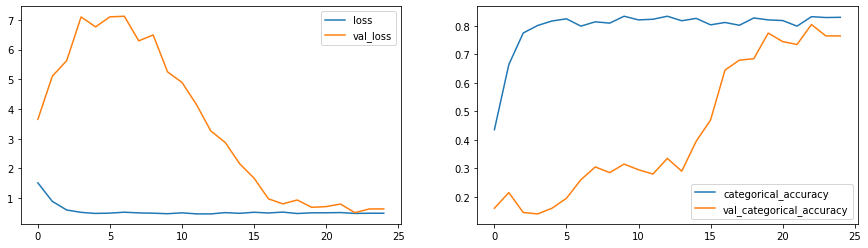

In [25]:
plot(model_09_history)

### Results
|S. No. | Model Name | Batch_size | Epochs | Total_Frames | IMG_Height | IMG_Width | Training_Accuracy | Validation_Accuracy | Training Loss | Validation Loss | Observation | Next Step |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|09| Model_arch_01 | 20 | <b>25</b> | 20 | 120 | 120 |0.8303 | 0.8050 | 0.4904 | 0.5100 | <b> Model performance seems to be DECENT </b>| Let's FREEZE this model|
|08| Model_arch_01 | 20 | <b>25</b> | 20 | 120 | 120 | 0.6410 | 0.3050 | 0.9323 | 3.7757 | <b> Model is learning but overfitting can be observed </b>| Let's try to keep same set up as experiment 07 and consider dropout change 0.5->0.25|
|07| Model_arch_01 | 20 | <b>25</b> | 20 | 120 | 120 | 0.5045 | 0.7350    | 1.2689 | 0.8047 | <b> Model is learning but underfitting can be observed </b>| Let's try to increase dense connections 64->128|
|06| Model_arch_01 | 20 | 05 | 20 | 120 | 120 | 0.7044 | 0.2600 | 0.7819 | 10.3581 | <b> Model is learning though validation loss is high </b>| Let's try to increase epoch count from 5->25|
|05| Model_arch_01 | 20 | 05 | 20 | 160 | 160 | 0.6991 | 0.3150 | 0.8275 | 6.7342 | <b> Model is learning and giving better validation accuracy </b>| Let's try to change image height & width|
|04| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.5807 | 0.1400 | 1.1205 | 10.0454   | <b> Model is learning though overfitting continues  </b>| Let's reduce number of frames in case model is learning noise|
|03| Model_arch_01 | 20 | 05 | 30 | 160 | 160 | 0.8054 | 0.1350 |0.5465   | 3.8519   | <b> Model is Overfitted</b>| Let's change drop 0.25 -> 0.5|
|02| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | 0.9291   |0.1800 | 0.2194 | 8.0599  | <b> Model is Overfitting</b>| Let's to simplify model, reduce dense connection 256->64|
|01| Model_arch_01 | 32 | 05 | 30 | 160 | 160 | NA  | NA | NA | NA | Batch size is more than the available memory| Let's try batch size of 20|

# Architecture 02: 2DCNN + GRU

In [65]:
def build_Conv_GRUnet02(shape=(30,112, 112, 3), learn_rate=0.0002, dense_neurons=64, dropout=0.25):
    filtersize = (3,3)
    model = Sequential()
    model.add(Conv2D(16, filtersize, padding='same',
                 input_shape=(shape[1], shape[2], shape[3])))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    #flatten
    model.add(GlobalMaxPool2D())
    
    gru_model = Sequential()
    gru_model.add(TimeDistributed(model, input_shape=shape))
    # let's use GRU
    gru_model.add(GRU(64))
    # and finally, we make a decision network
    gru_model.add(Dense(1024, activation='relu'))
    gru_model.add(Dropout(dropout))
    gru_model.add(Dense(512, activation='relu'))
    gru_model.add(Dropout(dropout))
    gru_model.add(Dense(128, activation='relu'))
    gru_model.add(Dropout(dropout))
    gru_model.add(Dense(64, activation='relu'))
    gru_model.add(Dense(num_classes, activation='softmax'))
    
    
    optimiser = tf.optimizers.Adam(learning_rate=learn_rate)
    gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
    
    return gru_model

## Experiment 10: 2D CNN + GRU

In [63]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=20
print ('# total_frames =', total_frames)
img_height = 120
print ('# img_height =', img_height)
img_width = 120
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_10 = build_Conv_GRUnet02((sample_frames,img_height, img_width,3), dense_neurons=128, dropout=0.25)
print (model_10.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_10_history = model_10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 25
# total_frames = 30
# img_height = 120
# img_width = 120
# batch_size = 20
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 20, 512)          1576800   
 tributed)                                                       
                                                                 
 gru_5 (GRU)                 (None, 64)                110976    
                                                                 
 dense_27 (Dense)            (None, 1024)              66560     
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               524800    
                                                                 
 dropout_18 (Dropout)        (

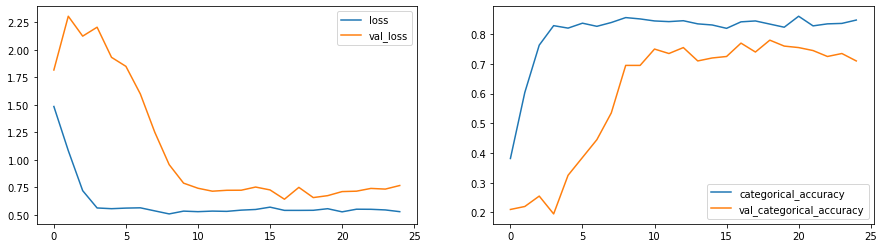

In [64]:
plot(model_10_history)

# Arch 03: 3DCNN Based (#not tried though)

In [14]:
## Model Architecture 03: let's try Arch 01 with filet size as (2,2,2)

In [12]:
def build_3DConv_net03(shape=(30,112, 112, 3), learn_rate=0.0002, dense_neurons=64, dropout=0.25):
    filtersize = (2,2,2)
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))


    model.add(Dense(num_classes,activation='softmax'))
        
    optimiser = tf.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
    
    return model

### Experiment 11: Try to execute Experiment 09 with Model Arch 03

In [13]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
sample_frames=20
print ('# total_frames =', total_frames)
img_height = 120
print ('# img_height =', img_height)
img_width = 120
print ('# img_width =', img_width)
batch_size = 20 #experiment with the batch size
print ('# batch_size =', batch_size)

model_11 = build_3DConv_net03((sample_frames, img_height, img_width,3), dense_neurons=128, dropout=0.25)
print (model_11.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

train_generator = generator(train_path, train_doc, batch_size,sample_frames,img_height, img_width, augment=True)
val_generator = generator(val_path, val_doc, batch_size,sample_frames,img_height, img_width, augment=True)

model_11_history = model_11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# epochs = 25
# total_frames = 30
# img_height = 120
# img_width = 120
# batch_size = 20


2022-06-12 10:00:22.784622: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-12 10:00:22.784701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 32)    0

2022-06-12 10:00:26.962946: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6165 - categorical_accuracy: 0.3944
Epoch 00001: saving model to model_init_2022-06-1209_59_37.165075/model-00001-1.61655-0.39442-1.97565-0.21500.h5
34/34 [==============================] - 87s 3s/step - loss: 1.6165 - categorical_accuracy: 0.3944 - val_loss: 1.9756 - val_categorical_accuracy: 0.2150 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.9870 - categorical_accuracy: 0.6267
Epoch 00002: saving model to model_init_2022-06-1209_59_37.165075/model-00002-0.98705-0.62670-3.08601-0.19000.h5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
34/34 [==============================] - 83s 3s/step - loss: 0.9870 - categorical_accuracy: 0.6267 - val_loss: 3.0860 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.8020 - categorical_accuracy: 0.6938
Epoch 00003: saving model to model_init_2022-

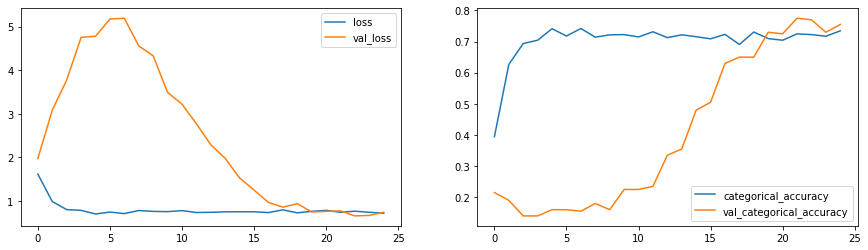

In [15]:
plot(model_11_history)